In [1]:
#importing lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

In [2]:
#setting date column as index
df=pd.read_csv(r"/content/GE.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date',inplace=True)



In [3]:
#scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(df)
df_s = scaler.transform(df)
len(df_s)


15388

In [4]:
df_s[0]

array([0.00099811, 0.00100296, 0.00102914, 0.00097882, 0.00275414])

In [5]:
#splitting data into train and test dataset
train_size = int(len(df_s) * 0.9)
validation_size = int(train_size * 0.05)
test_size = int(train_size * 0.05)

train_data = df_s[:train_size]
val_data = df_s[train_size:train_size + validation_size]
test_data = df_s[train_size + validation_size:train_size + validation_size + test_size]

window_size=10

In [6]:
#function for window size
def df_to_x_y(data, window_size=10):

  X = []
  y = []
  for i in range(len(data)-window_size):
    row = [r for r in data[i:i+window_size]]
    X.append(row)

    label = [data[i+window_size][3]]
    y.append(label)
  return np.array(X), np.array(y)

In [7]:
x_train,y_train = df_to_x_y(train_data)
x_val,y_val=df_to_x_y(val_data)
x_test,y_test=df_to_x_y(test_data)


In [8]:
train_X = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 5))
test_X = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 5))
val_X = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 5))

In [9]:
print(x_train[1][window_size-1][3])
print(y_train[0])

0.0008528830876278061
[0.00085288]


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from keras.utils import plot_model
from keras.models import load_model


In [11]:
tf.keras.backend.clear_session()

In [12]:
#CNN-LSTM model
model = Sequential()

model.add(Conv1D(filters=128,  kernel_size= 1, activation='tanh',padding='same',input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(MaxPooling1D(pool_size=1, padding='same'))
model.add(LSTM(units=256, return_sequences=True,activation='tanh'))

model.add(Dropout(0.4))

model.add(Conv1D(filters=64,  kernel_size= 1, activation='tanh',padding='same',input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(MaxPooling1D(pool_size=1, padding='same'))
model.add(LSTM(units=128, return_sequences=True,activation='tanh'))

model.add(Dropout(0.2))

model.add(Conv1D(filters=32,  kernel_size= 1, activation='tanh',padding='same',input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(MaxPooling1D(pool_size=1, padding='same'))
model.add(LSTM(units=64, return_sequences=True,activation='tanh'))


model.add(Dense(1))
model.compile(loss=Huber(), optimizer='adam',metrics = ['mse', 'mae'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 128)           768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 128)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 10, 256)           394240    
                                                                 
 dropout (Dropout)           (None, 10, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 64)            16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 64)           0         
 1D)                                                    

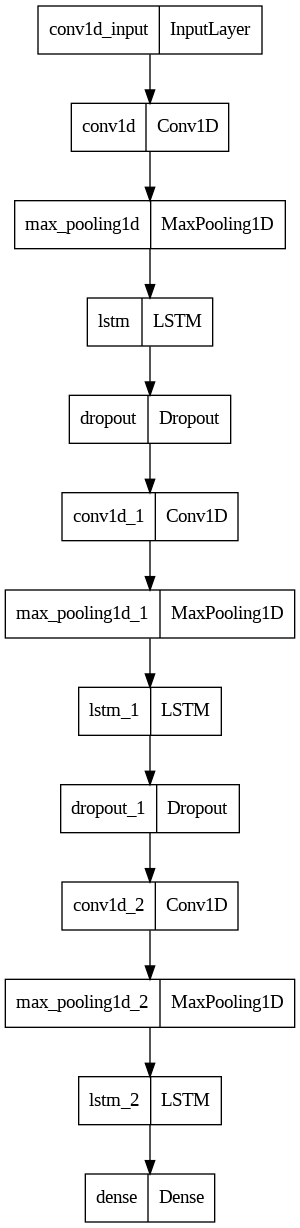

In [13]:
plot_model(model, to_file='model.png')

In [14]:
history=model.fit(x_train, y_train, epochs=50,validation_data=(x_val,y_val),batch_size=64,)

Epoch 1/50
217/217 [==============================] - 14s 19ms/step - loss: 0.0035 - mse: 0.0070 - mae: 0.0357 - val_loss: 3.6985e-04 - val_mse: 7.3971e-04 - val_mae: 0.0199
Epoch 2/50
217/217 [==============================] - 2s 11ms/step - loss: 2.6100e-04 - mse: 5.2200e-04 - mae: 0.0137 - val_loss: 3.0312e-04 - val_mse: 6.0623e-04 - val_mae: 0.0183
Epoch 3/50
217/217 [==============================] - 2s 11ms/step - loss: 2.5098e-04 - mse: 5.0196e-04 - mae: 0.0133 - val_loss: 3.2905e-04 - val_mse: 6.5810e-04 - val_mae: 0.0202
Epoch 4/50
217/217 [==============================] - 2s 11ms/step - loss: 2.2418e-04 - mse: 4.4835e-04 - mae: 0.0125 - val_loss: 3.6287e-04 - val_mse: 7.2575e-04 - val_mae: 0.0206
Epoch 5/50
217/217 [==============================] - 3s 14ms/step - loss: 2.2600e-04 - mse: 4.5201e-04 - mae: 0.0127 - val_loss: 3.4738e-04 - val_mse: 6.9477e-04 - val_mae: 0.0200
Epoch 6/50
217/217 [==============================] - 2s 11ms/step - loss: 2.2178e-04 - mse: 4.4355e-0

In [15]:
model.save('my_model_100.h5')

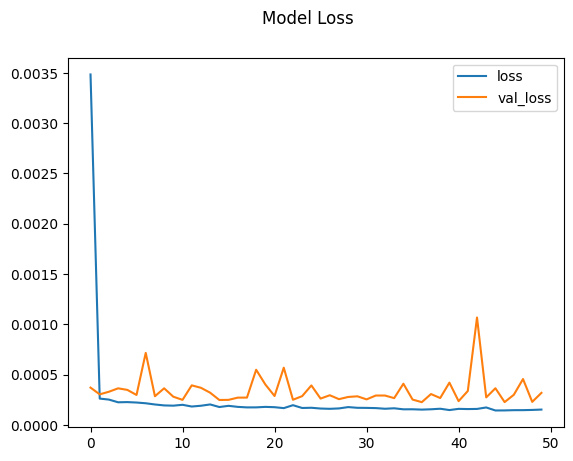

In [16]:
plt.suptitle('Model Loss')
plt.plot(history.epoch, history.history['loss'], label='loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [17]:

yhat=model.predict(x_test)


22/22 [==============================] - 2s 8ms/step


In [18]:
yhat.shape

(682, 10, 1)

In [19]:
yp=yhat[:,3]
yp.shape

(682, 1)

In [20]:
# create empty table with 12 fields
testPredict_dataset_like = np.zeros(shape=(len(yp), 5) )

# put the predicted values in the right field
testPredict_dataset_like[:,0] = yp[:,0]

# inverse transform and then select the right field
testPredict = scaler.inverse_transform(testPredict_dataset_like)[:,0]



In [21]:
testPredict=testPredict.reshape(testPredict.shape[0],1)

In [22]:
y_test.shape

(682, 1)

In [23]:
test = np.zeros(shape=(len(y_test), 5) )

# put the predicted values in the right field
test[:,0] = y_test[:,0]

# inverse transform and then select the right field
tests = scaler.inverse_transform(test)[:,0]


In [24]:
tests=tests.reshape(tests.shape[0],1)

In [25]:
rmse = np.sqrt(np.mean((testPredict - tests) ** 2))

print(f'The RMSE for stock is {rmse}')

The RMSE for stock is 4.871221143428408


In [26]:
testPredict.shape

(682, 1)

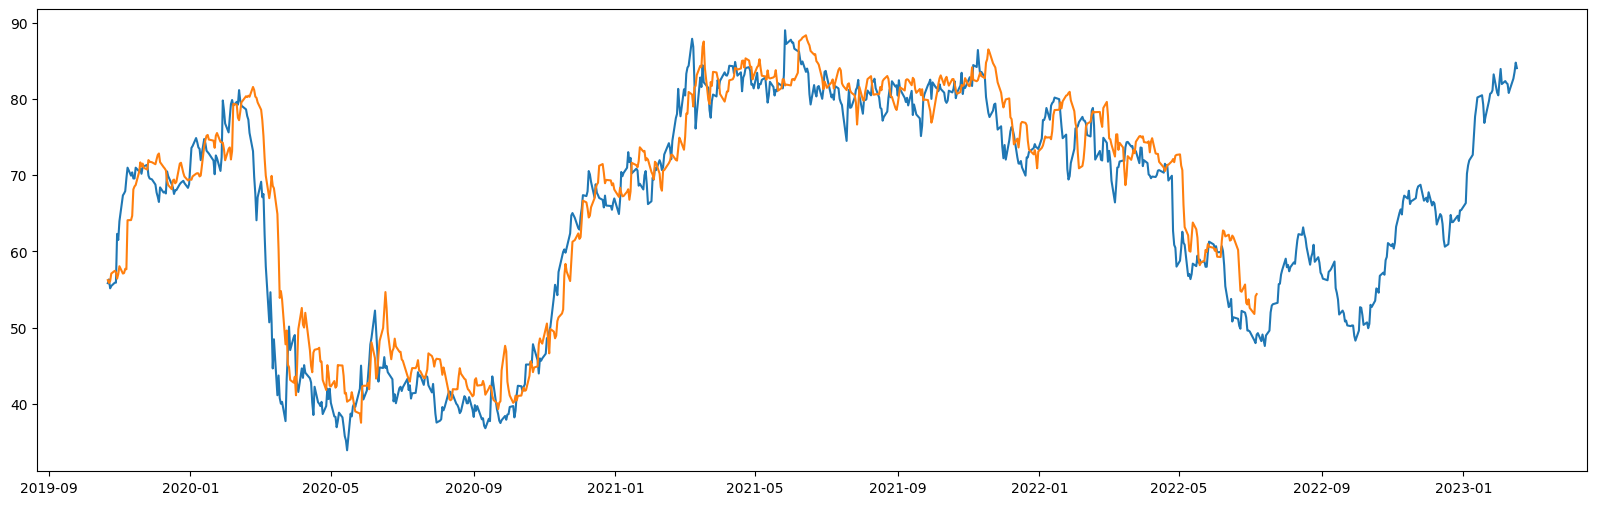

In [27]:
plt.figure(figsize=(20,6))
plt.plot(df.index[train_size+validation_size+window_size:],df.iloc[train_size+validation_size+window_size:,3], label='Actual')
plt.plot(df.index[train_size+validation_size+window_size:train_size+validation_size+window_size+682],testPredict, label='Actua')

plt.show()